In [1]:
# 次元削減のメリット
# ここでいう次元とは特徴量数のこと
# ●訓練スピードが上がる
# ●次元を2、または3まで下げることが出来た場合、グラフで可視化できる

# 次元削減のデメリット
# ●データ劣化の可能性がある
# ●パイプラインが少し複雑になる

In [2]:
# 次元の呪い
# 次元が増えると境界とインスタンスの距離が離れるため、予測信頼性が下がる。　＝過学習のリスクが大きくなる
# 回避方法１：訓練セットを大きくする　⇒　次元が増えると必要な訓練セットも大きくなるためこれでは対処しきれない
# それ以外の回避方法は以下２つの理論

In [3]:
# 射影
# 訓練セットは特徴量の次元に満遍なく散らばっているわけではなく、実際には高次元空間と比べて次元の低い部分空間に収まっている
# そこで次元を削減することで3次元のデータを2次元にしてもデータ劣化を防ぐことができる
# ただし部分空間(実際のデータの散らばり)が捻じれていたり、回転していると次元削減の際に押しつぶされて情報がれっかしてしまう

In [4]:
# 多様体学習
# 実世界の高次元データはもっと低次元の多様体に近いという仮定に基づいた学習方法(多くのアルゴリズムで採用している)
# ただし、モデルを訓練する前に盲目的に次元を削減すると訓練スピードは速くなるが最適解に辿り着くとは限らない。データ次第であることを注意

In [5]:
# ここから先は具体的なアルゴリズムで次元削減をしていく
# お決まり設定
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [6]:
# 3D データセットを作っておく
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

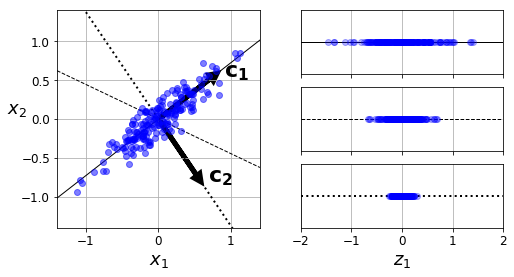

In [7]:
# PCA 主成分分析
# 単純な２次元データを削減してみる
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.savefig("pca_best_projection")
plt.show()

# 左のグラフは元の次元データ
# 右のグラフは上段：実線(一番分散が残っている)。中段：破線(点線の次に分散が残っている)。下段：点線(実線と直交している)
# 主成分分析では第一の主成分は一番分散が残っているもの(ここでは実線)
# 第二の主成分は第一の主成分と直交しているもの　となる(ここでは点線)
# この例での射影はこの二成分の次元平面に３次元データを描画する
# 

In [8]:
# scikit-learnを活用してPCAを実施してみる
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
# 因子寄与率
# 個々の主成分の軸に沿ったデータセット分散の分散全体に対する割合
pca.explained_variance_ratio_

# データセットの95%が第一軸にそっていることを示す

array([0.95369864, 0.04630136])

In [10]:
# 適切な次元数の選択
# グラフの可視化以外の場合、各次元の寄与率が95%程度で次元削減を止めたい。
pca = PCA(n_components = 0.95) # ここで0.0～1.0までの浮動小数点を指定すると分散の割合指定になる
X_reduced = pca.fit_transform(X)

In [11]:
# 圧縮のためのPCA
# MNISTを例に次元削減⇒次元の再構築を試してみる

# MNISTを準備
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [12]:
# データを訓練と検証に分割
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
# 95% まで次元を削減
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [14]:
# 削減後の次元数を見てみる　784⇒154
d

154

In [15]:
# 削減した次元から再構築してみる
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [16]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

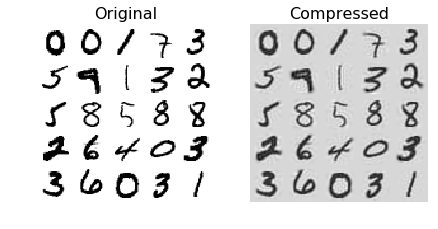

In [17]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

plt.savefig("mnist_compression_plot")

# 左の表は元の画像データ
# 右の表は元の画像データ⇒次元削減(154) ⇒次元再構築したもの

In [18]:
# 追加学習型PCA
# 単純なPCAでは訓練セット全体がメモリに収まっている必要がある。追加学習型PCAはミニバッチに分割してPCAを実行できる
# 個々のミニバッチを対象に partial_fit() メソッドを呼び出す


In [19]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100 # バッチ数の指定
inc_pca = IncrementalPCA(n_components=154) # 次元数の指定
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [20]:
X_reduced_pca = X_reduced

In [21]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

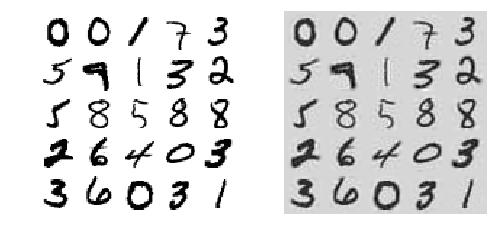

In [22]:
# 単純PCAと同様に復元結果を確認してみる
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [23]:
X_reduced_inc_pca = X_reduced

In [24]:
# np.allcloseは配列が同じか比べるメソッド
np.allclose(pca.mean_, inc_pca.mean_)

True

In [25]:
# 追加学習型はPCAに対して近似値を出せるが完ぺきではないことに注意
np.allclose(X_reduced_pca, X_reduced_inc_pca)

True